#Setup environment

In [1]:
!pip install gensim
!pip install umap-learn==0.3.10
!pip install transformers==2.1.1 tensorboard==1.9
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
!unzip glove.6B.zip

     |████████████████████████████████| 317kB 2.7MB/s 
     |████████████████████████████████| 3.3MB 37.0MB/s 
     |████████████████████████████████| 1.0MB 38.0MB/s 
     |████████████████████████████████| 860kB 43.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=7cd90d8deb0a9395b8f8f05513ff0b2c26639b6156b5082befb1ecb82cd601dd
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.9.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
--2019-12-22 16:33:22--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... conne

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

import umap.umap_ as umap

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import itertools
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, WarmupLinearSchedule
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [4]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

path_to_data = 'gdrive/My Drive/Colab Notebooks/project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Work with data

Dataset that we used can be downloaded from kaggle via this link: https://www.kaggle.com/rounakbanik/ted-talks

In [0]:
meta_data = pd.read_csv(os.path.join(path_to_data,'ted_main.csv'))

In [0]:
texts = pd.read_csv(os.path.join(path_to_data, 'transcripts.csv'))
texts['label'] = None

### Let's merge texts and their annotations

In [0]:
all_data = texts.merge(how='inner', on = 'url', right=meta_data)
all_data = all_data[['transcript', 'description', 'tags', 'label']]

### Then we can work with tags. 

Read tags

In [0]:
tags_set = []
for tag in meta_data['tags']:
    tags_set += eval(tag.lower())
tags_set = set(tags_set)

In [10]:
print('There are {} unique tags'.format(len(tags_set)))

There are 416 unique tags


#### Then we clean up some tags

In [0]:
transform_rule = {'ted books': 'books',
                  'ted brain trust': 'brain trust',
                  'ted en español' : 'en español',
                  'ted fellows' : 'fellows',
                  'ted prize': 'prize',
                  'ted residency' : 'residency',
                  'ted-ed' : 'education',
                  'tedmed' : 'medicine',
                  'tednyc' : 'nyc',
                  'tedx' : 'event',
                  'tedyouth' : 'youth', 
                  "alzheimer's": 'disease', 
                  'blockchain': 'informatics', 
                  'crispr':'biology', 'deextinction' : 
                  'rebirth'}

In [0]:
def tag_transform(tag, transform_rule):
    if tag in transform_rule.keys():
        tag = transform_rule[tag]
    tag = tag.replace('-', ' ').strip()
    return tag

In [0]:
tags_list = sorted(list(tags_set))
n_tags = len(tags_list)

tag_transform_one_param = lambda x: tag_transform(x, transform_rule)
tags_list = list(map(tag_transform_one_param, tags_list))
tags_list = sorted(list(set(tags_list)))

In [14]:
print('There are {} unique tags after transformation'.format(len(tags_list)))

There are 410 unique tags after transformation


Let's save tag2word and word2tag dictionaries for the future

In [0]:
word_to_tag_ixs = dict()
for tag_ix, tag in enumerate(tags_list):
    words = tag.split()
    for word in words:
        try:
            word_to_tag_ixs[word].append(tag_ix)
        except:
            word_to_tag_ixs[word] = [tag_ix]
all_tags_words = set(word_to_tag_ixs.keys())

In order to perform classification task we should reduce number of classes. To do that, let's cluster tags via their word embedding representation. We use `Glove` embedding.

#### Load Glove embeddings

In [16]:
glove_path = os.path.join(path_to_data, 'glove.6B.300d.txt')

tags_embeddings = dict(zip(tags_list, [[] for _ in range(len(tags_list))]))

with open(glove_path, 'r') as glove_file:
    line_ix = 0
    for line in tqdm(glove_file):
        line = line.strip('\n').split()
        word = line[0]
        if word in all_tags_words:
            word_emb = list(map(float, line[1:]))   
            for tag_ix in word_to_tag_ixs[word]: 
                tags_embeddings[tags_list[tag_ix]].append(word_emb)

400001it [00:16, 24699.54it/s]


Check that all the words present in embedding

In [0]:
for ix, embedding in enumerate(list(tags_embeddings.values())):
    assert (len(embedding) != 0), 'There is a word without embedding!'

Let's take average if we have more than 1 word in text

In [0]:
for tag in tags_embeddings.keys():
    tags_embeddings[tag] = np.mean(tags_embeddings[tag], axis=0)

In [0]:
for tag in tags_embeddings.keys():
    assert (tags_embeddings[tag].shape[0] == 300), 'Bad dimension'

### In order to reduce embedding dimension of our words we can use PCA

In [0]:
X_tags = np.array(list(tags_embeddings.values()))

In [0]:
pca_transform = PCA(n_components=2)
X_tags_2dim = pca_transform.fit_transform(X_tags)

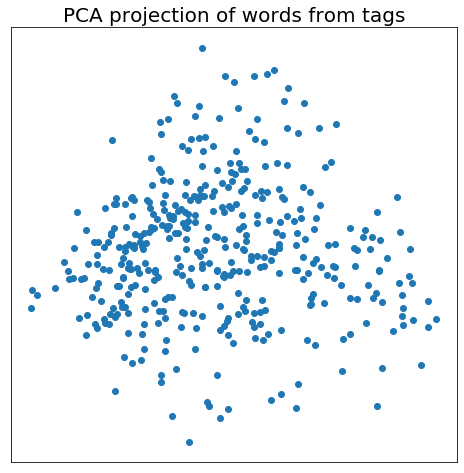

In [22]:
plt.figure(figsize=(8,8))
plt.title('PCA projection of words from tags', fontsize = 20)
plt.scatter(X_tags_2dim[:, 0], X_tags_2dim[:, 1])
_ = plt.xticks([])
_ = plt.yticks([])

Also we can estimate components variance

In [0]:
U, Sigma, V_T = np.linalg.svd(X_tags)

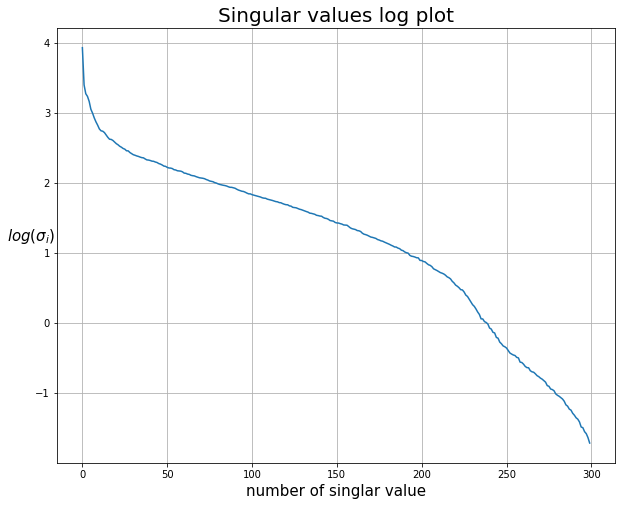

In [24]:
plt.figure(figsize=(10, 8))
plt.title('Singular values log plot', fontsize=20)
plt.xlabel('number of singlar value', fontsize=15)
h = plt.ylabel(r'$log( \sigma_i )$', fontsize=15)
h.set_rotation(0)
plt.grid(True)
plt.plot(np.log(Sigma))

#### We can see that PCA does not really show clusters, so let's use 50 PCA components as input data for UMAP algorithm

In [0]:
import umap.umap_ as umap

In [0]:
new_pca_transform = PCA(n_components=50)
X_tags_50dim = new_pca_transform.fit_transform(X_tags)

In [0]:
reducer = umap.UMAP()
X_tags_umapped = reducer.fit_transform(X_tags_50dim)

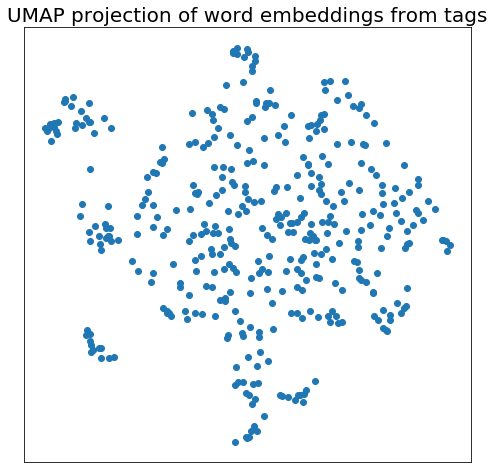

In [28]:
plt.figure(figsize=(8, 8))
plt.title('UMAP projection of word embeddings from tags', fontsize=20)
plt.scatter(X_tags_umapped[:, 0], X_tags_umapped[:, 1])
_ = plt.xticks([])
_ = plt.yticks([])

Now let's cluster tags with __agglomerative clustering__.

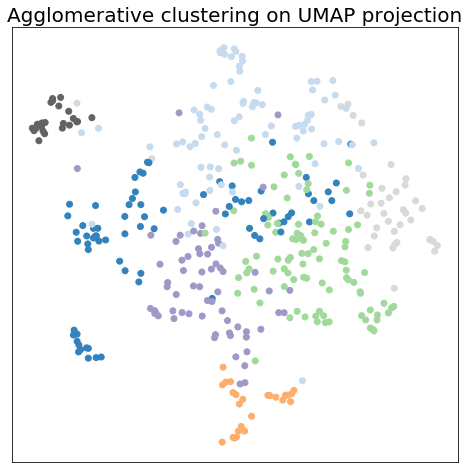

In [29]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X_tags)
labels_from_clustering = np.array(clustering.labels_)

plt.figure(figsize=(8,8))
plt.title('Agglomerative clustering on UMAP projection', fontsize=20)
plt.scatter(X_tags_umapped[:, 0], X_tags_umapped[:, 1], c=labels_from_clustering, cmap='tab20c')
_ = plt.xticks([])
_ = plt.yticks([])

Now we can look at tags and check if clusters are meaningfull

In [30]:
tags_list = np.array(tags_list)
df_to_show = pd.DataFrame(columns = np.arange(n_clusters))
num_words_to_show = 10
for cluster_value in range(n_clusters):
    df_to_show[cluster_value] = tags_list[labels_from_clustering == cluster_value][:num_words_to_show]
df_to_show.head(num_words_to_show)

,0,1,2,3,4,5,6
0,ai,3d printing,addiction,africa,activism,anthropology,agriculture
1,aircraft,adventure,aids,aging,ancient world,archaeology,alternative energy
2,algorithm,advertising,autism spectrum disorder,asia,atheism,astronomy,biodiversity
3,animals,animation,blindness,big bang,beauty,behavioral economics,biotech
4,anthropocene,architecture,cancer,big problems,brain,bioethics,climate change
5,ants,art,depression,brazil,brain trust,biology,conservation
6,apes,augmented reality,disability,business,buddhism,botany,disaster relief
7,asteroid,body language,disease,charter for compassion,bullying,chemistry,discovery
8,astrobiology,books,ebola,children,capitalism,economics,ecology
9,bacteria,brand,health,china,christianity,epidemiology,energy


In [31]:
for i in range(n_clusters):
    print(f"Cluster {i} has len:", len(tags_list[labels_from_clustering == i]))

Cluster 0 has len: 77
Cluster 1 has len: 84
Cluster 2 has len: 25
Cluster 3 has len: 98
Cluster 4 has len: 64
Cluster 5 has len: 24
Cluster 6 has len: 38


So, we can conclude that clusters are more or less meaningfull.

Now we can try to automaticly find a title for each cluster by searching for `Nearest Neighbour` in embedding space for cluster center.

In [0]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
def compute_distance(x, y, metric='euclidean'):
    if metric=='euclidean':
        return np.linalg.norm(x - y)
    elif metric=='cosine':
        return 1 - (np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y))

def cluster_i_mean(i, embeddings, tags, labels):
    cluster_i_emb = [embeddings[tag] for tag in tags[labels == i]]
    return np.mean(cluster_i_emb, axis=0)

def nearest_neighbour(word, embedding, metric='euclidean'):
    cur_min = np.inf
    for vector in embedding.keys():
        cur_dist = compute_distance(word, embedding[vector], metric)
        if cur_dist < cur_min:
            cur_min = cur_dist
            res = vector
    return res

In [0]:
#we ran this in colab, mind the memory
glove = {}
for line in open(glove_path):
    line = line.strip('\n').split()
    word, emb = line[0], line[1:]
    if word not in set('.,?!*^&@#%<>{}[]'):
        emb = np.array([float(e) for e in emb])
        glove[word] = emb

In [34]:
for i in range(n_clusters):
    print('searching NN for {} cluster...'.format(i))
    cluster_mean = cluster_i_mean(i, tags_embeddings, tags_list, labels_from_clustering)
    cluster_title = nearest_neighbour(cluster_mean, glove, 'cosine')
    df_to_show = df_to_show.rename(columns = {i: cluster_title})

searching NN for 0 cluster...
searching NN for 1 cluster...
searching NN for 2 cluster...
searching NN for 3 cluster...
searching NN for 4 cluster...
searching NN for 5 cluster...
searching NN for 6 cluster...


In [35]:
df_to_show.head(8)

,humans,music,disease,that,sense,biology,energy
0,ai,3d printing,addiction,africa,activism,anthropology,agriculture
1,aircraft,adventure,aids,aging,ancient world,archaeology,alternative energy
2,algorithm,advertising,autism spectrum disorder,asia,atheism,astronomy,biodiversity
3,animals,animation,blindness,big bang,beauty,behavioral economics,biotech
4,anthropocene,architecture,cancer,big problems,brain,bioethics,climate change
5,ants,art,depression,brazil,brain trust,biology,conservation
6,apes,augmented reality,disability,business,buddhism,botany,disaster relief
7,asteroid,body language,disease,charter for compassion,bullying,chemistry,discovery


We can see that most clusters have good titles, but clusters `that` and `sense` are not really good. 

We suggest that those clusters are of very common and general terms and this is why average vector of them is a very unspecific word.

We've tried to change number of clusters or clustering technique, but these persisntly continued to appear.

That is why we decided to remove all tags, that belong to these clusters from the dataset.

In [36]:
for i in [3,4]:
    print(f"Cluster {i}: ", tags_list[labels_from_clustering == i])
    print()

Cluster 3:  ['africa' 'aging' 'asia' 'big bang' 'big problems' 'brazil' 'business'
 'charter for compassion' 'children' 'china' 'choice' 'cities'
 'collaboration' 'communication' 'community' 'corruption' 'crime'
 'criminal justice' 'culture' 'death' 'debate' 'decision making'
 'democracy' 'egypt' 'europe' 'event' 'failure' 'family' 'fear' 'finance'
 'foreign policy' 'friendship' 'future' 'goal setting' 'government'
 'hearing' 'immigration' 'india' 'intelligence' 'interview' 'investment'
 'iran' 'iraq' 'law' 'leadership' 'media' 'men' 'middle east' 'military'
 'mission blue' 'money' 'narcotics' 'new york' 'news' 'nobel prize' 'nyc'
 'open source' 'peace' 'personal growth' 'play' 'policy' 'politics'
 'population' 'potential' 'prison' 'prize' 'protests' 'public spaces'
 'race' 'refugees' 'relationships' 'security' 'shopping' 'social change'
 'social media' 'society' 'south america' 'speech' 'state building'
 'success' 'suicide' 'syria' 'television' 'terrorism' 'time' 'trafficking'
 'trave

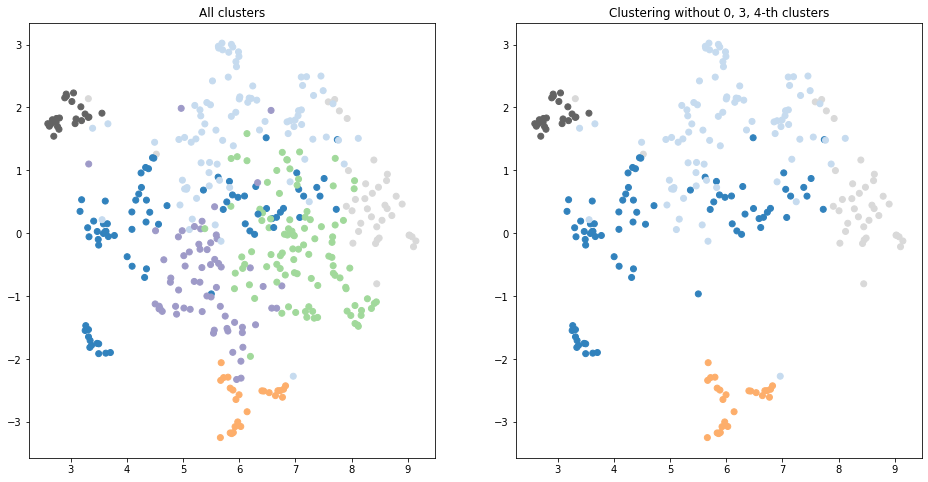

In [37]:
plt.figure(figsize=(16,8))


plt.subplot(1,2,1)
plt.title('All clusters')
plt.scatter(X_tags_umapped[:, 0], 
            X_tags_umapped[:, 1], 
            c=labels_from_clustering, cmap='tab20c')

plt.subplot(1,2,2)
plt.title('Clustering without 0, 3, 4-th clusters')
exclude_clusters = [3,4]
plt.scatter(X_tags_umapped[~np.isin(labels_from_clustering, exclude_clusters)][:, 0], 
            X_tags_umapped[~np.isin(labels_from_clustering, exclude_clusters)][:, 1], 
            c=labels_from_clustering[~np.isin(labels_from_clustering, exclude_clusters)], cmap='tab20c');


Overall, clustering became better now

#### We can apply changes to dataset

In [0]:
tag2cluster = {}
for i in range(len(tags_list)):
    tag2cluster[tags_list[i]] = labels_from_clustering[i]

In [39]:
set(tag2cluster.values())

{0, 1, 2, 3, 4, 5, 6}

Removing clusters 3, 4

In [0]:
n_clusters -= 2
all_tags = tag2cluster.keys()
for tag in all_tags:
    if tag2cluster[tag] in [3, 4]:
        tag2cluster[tag] = None
    elif tag2cluster[tag] > 4:
        tag2cluster[tag] -= 2

In [0]:
for i in range(len(all_data)):
    all_data['tags'][i] = eval(all_data['tags'][i].lower())
    for j in range(len(all_data['tags'][i])):
        all_data['tags'][i][j] = tag_transform(all_data['tags'][i][j], transform_rule)

For each ted talk we have several tags. As different tags could be assigned to different clusters, 
we construct dict {cluster_number: number of tags of this cluster} for each sample.

In [0]:
for i in range(len(texts)):
    clusters = {}
    to_remove = []
 
    for tag in all_data['tags'][i]:
        value = tag2cluster[tag]
    
        if value==None:
            to_remove.append(tag)

        elif value not in clusters:
            clusters[value] = 1

        else:
            clusters[value] += 1
  
    for tag in to_remove:
        all_data['tags'][i].remove(tag)
    all_data['label'][i] = clusters

### In order to simplify the task we can choose the most suitable cluster for each sample

Although, in further analysis we will try to use all information 

In [0]:
def choose_max(labels_dict):
    if labels_dict:
        keys = np.array(list(labels_dict.keys()))
        values = np.array(list(labels_dict.values()))
        return int(keys[np.argmax(values)])
    else:
        return None

In [0]:
all_data['major_label'] = all_data['label'].apply(choose_max)

In [0]:
all_data = all_data[~np.isnan(all_data['major_label'])]

Also let's plot distribution of samples per cluster

In [0]:
cluster_names = 'humans music disease biology energy'.split()

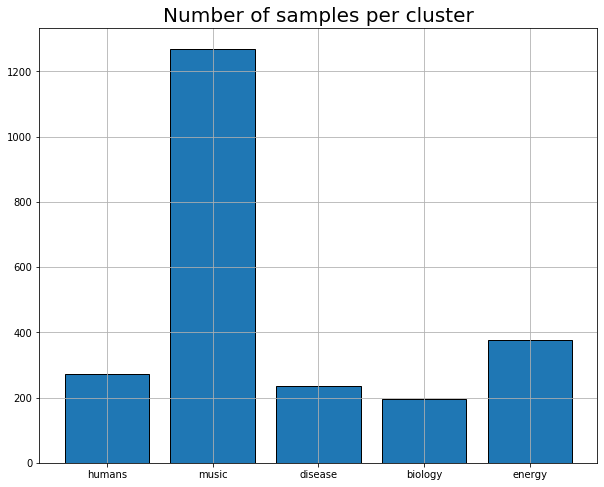

In [47]:
values, counts = np.unique(all_data['major_label'].to_numpy(), return_counts=True)

plt.figure(figsize=(10, 8))
plt.title('Number of samples per cluster', fontsize=20)
plt.grid(True)
plt.bar(values, counts, edgecolor = 'black')
_ = plt.xticks(np.arange(n_clusters), cluster_names)

In [48]:
len(all_data)

2351

In [0]:
all_data.to_csv(os.path.join(path_to_data, 'all_data_labeled.tsv'), index=None, sep = '\t')

Now lets check performance of different approaches that we studied during the course

# Simple models

In [0]:
methods_performance = dict()

## Text preparation

In [0]:
all_data = pd.read_csv(path_to_data+'all_data_labeled.tsv', sep = '\t')

### Tokenization

In [52]:
%%time
print('transcript tokenization...')
all_data['transcript'] = all_data['transcript'].apply(word_tokenize)

print('description tokenization')
all_data['description'] = all_data['description'].apply(word_tokenize)

transcript tokenization...
description tokenization
CPU times: user 40.6 s, sys: 259 ms, total: 40.8 s
Wall time: 40.9 s


### Stemmization

In [0]:
def sentence_stem(sent, stemmer):
    return [stemmer.stem(word) for word in sent]

In [0]:
stemmer = PorterStemmer()

In [55]:
%%time
print('transcript stemmization...')
all_data['transcript'] = all_data['transcript'].apply(lambda x: sentence_stem(x, stemmer))

print('description stemmization...')
all_data['description'] = all_data['description'].apply(lambda x: sentence_stem(x, stemmer))

transcript stemmization...
description stemmization...
CPU times: user 1min 15s, sys: 224 ms, total: 1min 15s
Wall time: 1min 15s


## Feature extraction

In [56]:
%%time
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english')
tfidf_matrix = tfidf.fit_transform(all_data['transcript'].apply(lambda x: ''.join(x))).toarray()

CPU times: user 8.44 s, sys: 297 ms, total: 8.74 s
Wall time: 8.75 s


Let's check how sparse our matrix is

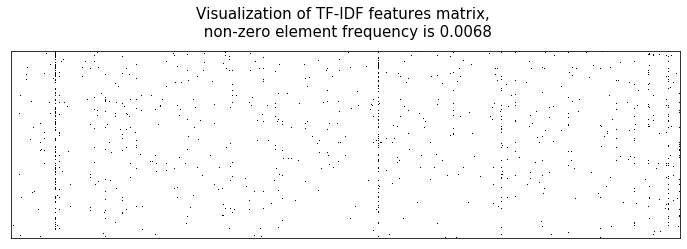

In [57]:
plt.figure(figsize=(12, 5))
plt.title('Visualization of TF-IDF features matrix, {0} non-zero element frequency is {1:.4f}'\
          .format('\n', np.count_nonzero(tfidf_matrix)/(tfidf_matrix.shape[0]  * tfidf_matrix.shape[1])), fontsize=15)
plt.spy(tfidf_matrix)
_ = plt.xticks([])
_ = plt.yticks([])

The matrix is very sparse which will make learning quite difficult, but we will try anyway

In [0]:
cluster_names = cluster_names = 'humans music disease biology energy'.split()
NUM_CLASSES = len(cluster_names)

labels = np.array(all_data['major_label'])

## Naive Bayes

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap='Blues'):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        _ = plt.yticks([])


    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=15)

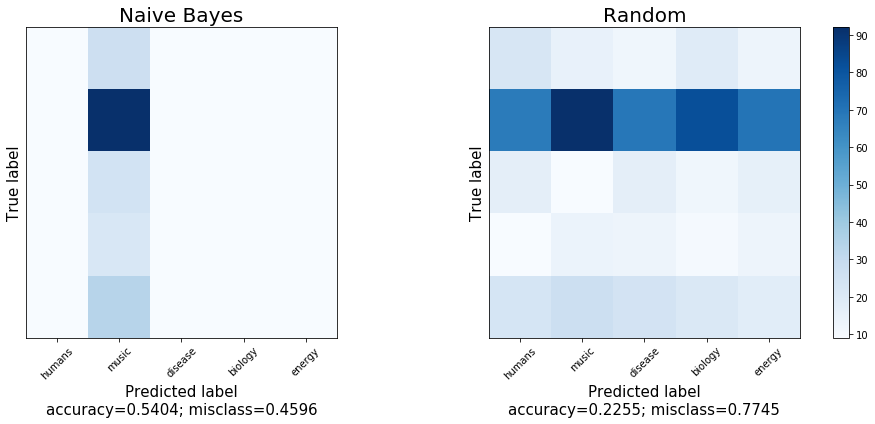

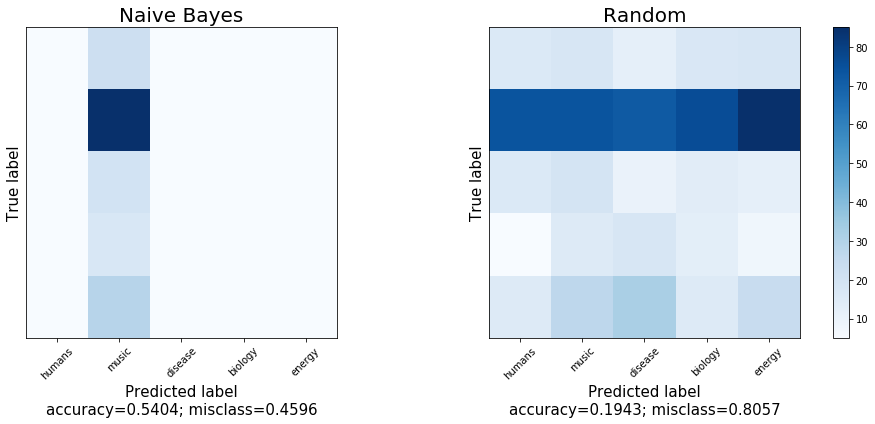

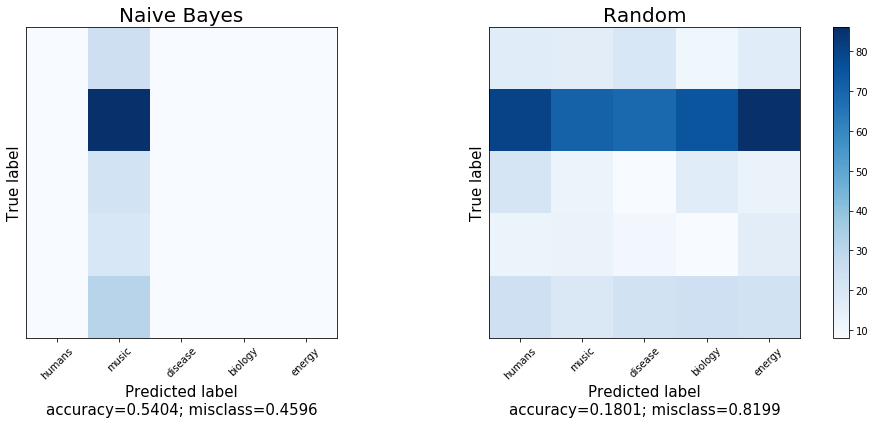

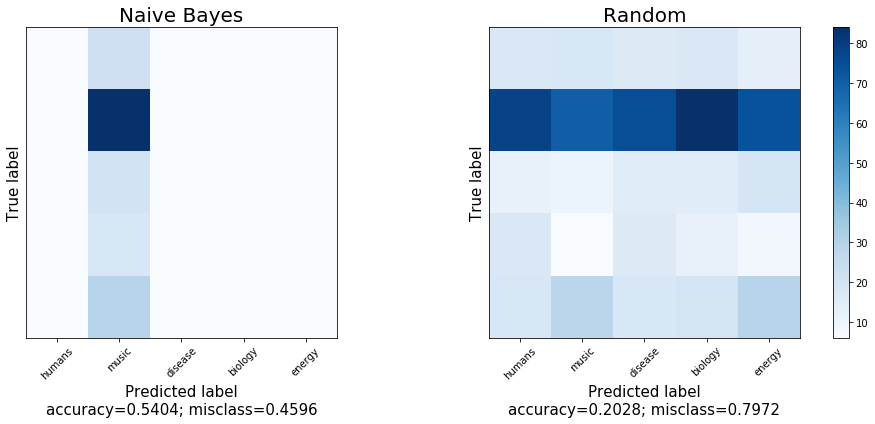

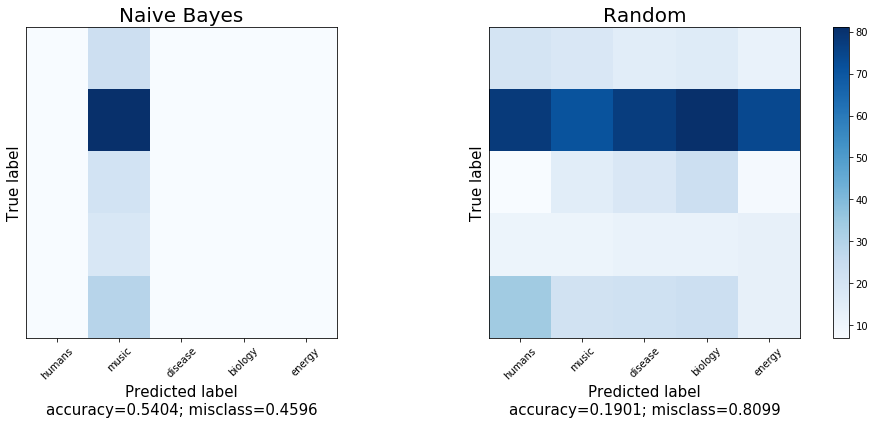

In [60]:
test_fraction = 0.3
number_of_splits = 5
sss = StratifiedShuffleSplit(n_splits=number_of_splits, 
                             test_size=int(test_fraction * len(all_data)))
splitted_ixs = sss.split(tfidf_matrix, labels)

current_accuracy = 0
for train_ixs, test_ixs in splitted_ixs:
    X_train, y_train = tfidf_matrix[train_ixs], labels[train_ixs]
    X_test, y_test = tfidf_matrix[test_ixs], labels[test_ixs]

    clf = MultinomialNB().fit(X_train, y_train)

    prediction = np.array(clf.predict(X_test))
    
    cm = confusion_matrix(y_test, prediction)
    
    # generate random labels

    rand_predictions = np.random.choice(np.arange(NUM_CLASSES), len(prediction))
    cm_rand = confusion_matrix(y_test, rand_predictions)

    #save accuracy
    current_accuracy += np.trace(cm) / float(np.sum(cm))

    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    plot_confusion_matrix(cm, target_names=cluster_names, title = 'Naive Bayes', cmap='Blues')

    plt.subplot(1,2,2)
    plot_confusion_matrix(cm_rand, target_names=cluster_names, title = 'Random', cmap='Blues')

In [0]:
current_accuracy  = current_accuracy/float(number_of_splits)
methods_performance['NB_all_data'] = current_accuracy

That's not very good, Naive Bayes consistently predicts one the most popular class. Yet it's still better than random. Let's try another approach...

## Logistic Regression

We will randomly split the data, do the gridsearch on train part and then validate on the test one

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linea

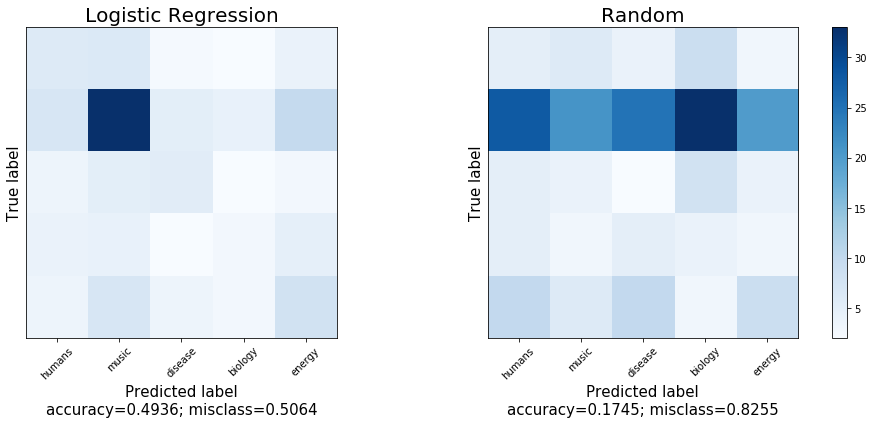

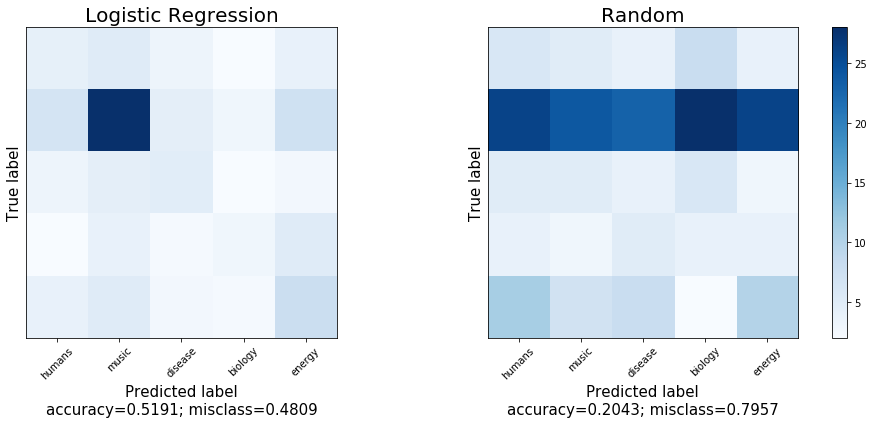

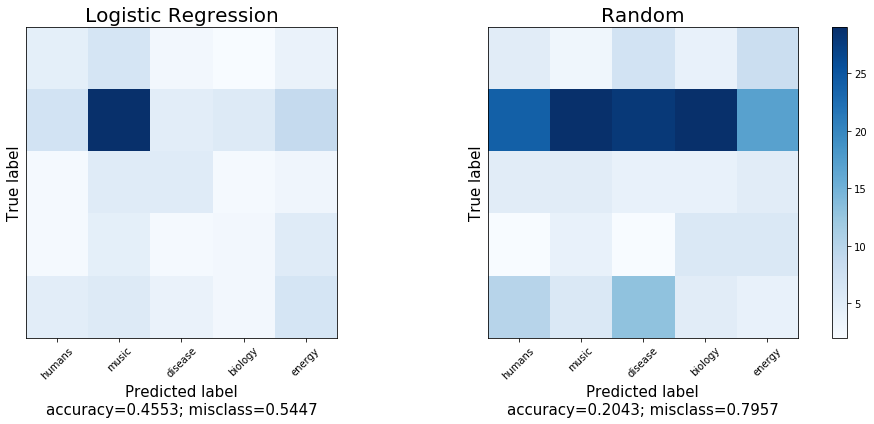

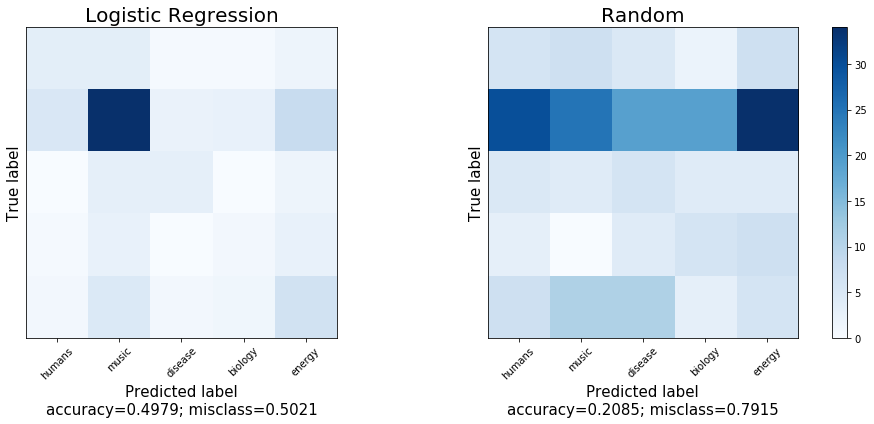

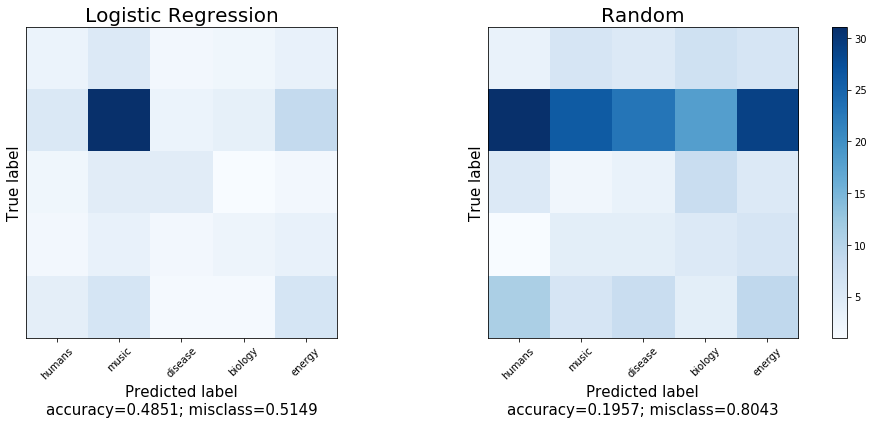

In [63]:
test_fraction = 0.1
number_of_splits = 5
sss = StratifiedShuffleSplit(n_splits=number_of_splits, 
                             test_size=int(test_fraction * len(all_data)))
splitted_ixs = sss.split(tfidf_matrix, labels)

current_accuracy = 0
for train_ixs, test_ixs in splitted_ixs:
    X_train, y_train = tfidf_matrix[train_ixs], labels[train_ixs]
    X_test, y_test = tfidf_matrix[test_ixs], labels[test_ixs]

    lr_model = LogisticRegression(n_jobs=-1, penalty='l2', C=0.1,
                                  max_iter=200, solver='saga', class_weight='balanced')

    lr_model.fit(X_train, y_train)

    
    prediction = np.array(lr_model.predict(X_test))
    
    cm = confusion_matrix(y_test, prediction)
    
    # generate random labels
    rand_predictions = np.random.choice(np.arange(NUM_CLASSES), len(prediction))
    cm_rand = confusion_matrix(y_test, rand_predictions)

    #save accuracy
    current_accuracy += np.trace(cm) / float(np.sum(cm))
    
    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    plot_confusion_matrix(cm, target_names=cluster_names, title = 'Logistic Regression', cmap='Blues')

    plt.subplot(1,2,2)
    plot_confusion_matrix(cm_rand, target_names=cluster_names, title = 'Random', cmap='Blues')

In [0]:
current_accuracy  = current_accuracy/float(number_of_splits)
methods_performance['LR_all_data'] = current_accuracy

Logistic regression is little better, but still very weak.The reason of this behavior for both classifiers might be that classes are very unbalanced. So we tried to check if these models yield better results in case of balanced dataset. So we applied undersampling technique.

# Undersampling
We took 200 samples from each class to balance them

## Data preparation

In [0]:
downsampled_data = pd.DataFrame(columns = all_data.columns)

In [0]:
for label in range(NUM_CLASSES):
    class_ixs = np.where(all_data['major_label'] == label)[0]
    chosen_class_ixs = np.random.choice(class_ixs, 200)
    chosen_data = all_data.iloc[chosen_class_ixs]
    downsampled_data = downsampled_data.append(chosen_data)

In [67]:
for i in range(NUM_CLASSES):
    print('Number of samples in class {} is: {}'.format(i+1, np.count_nonzero(downsampled_data['major_label'] == i)))

Number of samples in class 1 is: 200
Number of samples in class 2 is: 200
Number of samples in class 3 is: 200
Number of samples in class 4 is: 200
Number of samples in class 5 is: 200


In [68]:
%%time
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english')
tfidf_matrix = tfidf.fit_transform(downsampled_data['transcript'].apply(lambda x: ''.join(x))).toarray()

CPU times: user 2.65 s, sys: 54 ms, total: 2.7 s
Wall time: 2.7 s


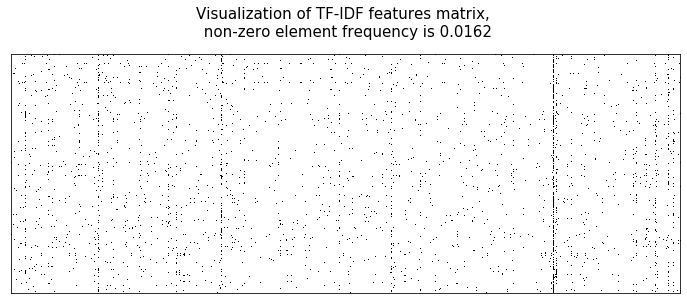

In [69]:
plt.figure(figsize=(12, 5))
plt.title('Visualization of TF-IDF features matrix, {0} non-zero element frequency is {1:.4f}'\
          .format('\n', np.count_nonzero(tfidf_matrix)/(tfidf_matrix.shape[0]  * tfidf_matrix.shape[1])), fontsize=15)
plt.spy(tfidf_matrix)
_ = plt.xticks([])
_ = plt.yticks([])

In [0]:
labels = np.array(downsampled_data['major_label'])

## Naive Bayes with undersampling

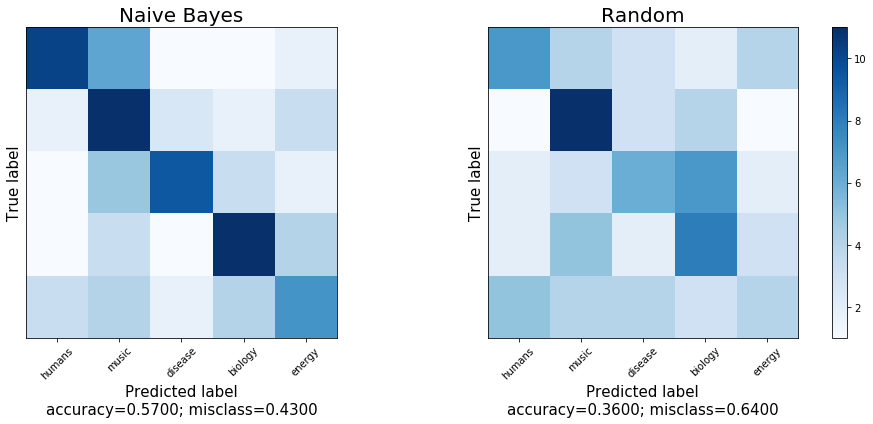

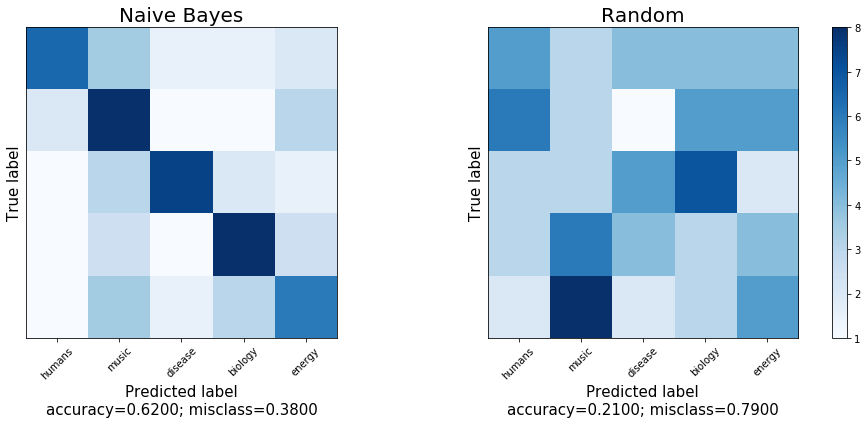

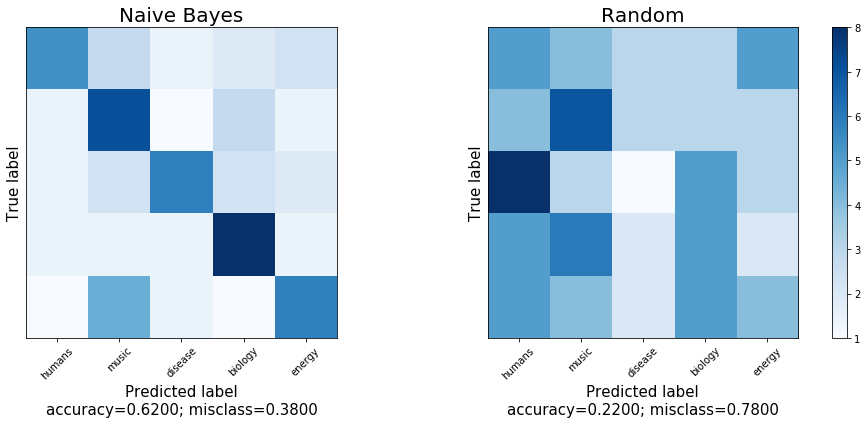

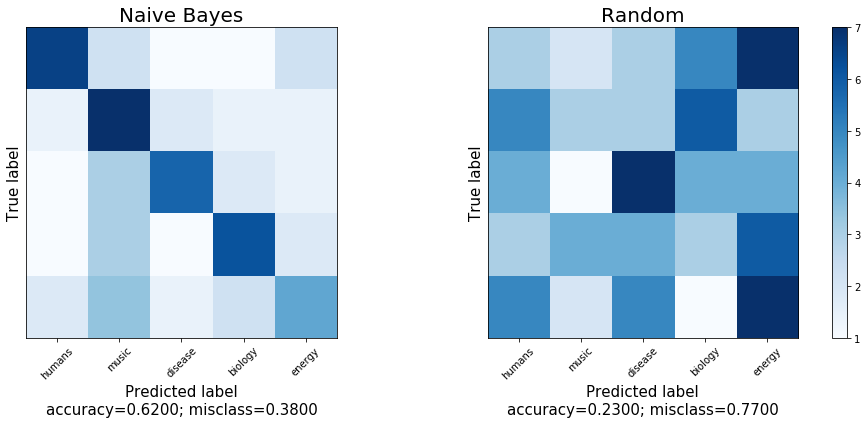

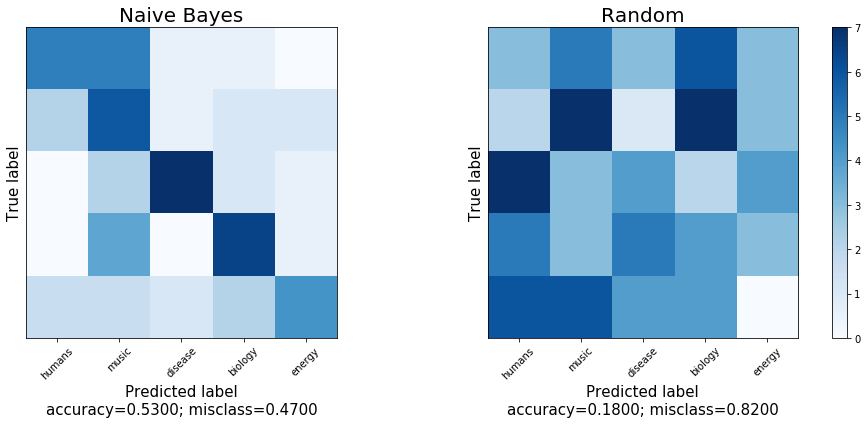

In [71]:
test_fraction = 0.1
number_of_splits = 5
sss = StratifiedShuffleSplit(n_splits=number_of_splits, 
                             test_size=int(test_fraction * len(downsampled_data)))
splitted_ixs = sss.split(tfidf_matrix, labels)

current_accuracy = 0
for train_ixs, test_ixs in splitted_ixs:
    X_train, y_train = tfidf_matrix[train_ixs], labels[train_ixs]
    X_test, y_test = tfidf_matrix[test_ixs], labels[test_ixs]

    clf = MultinomialNB().fit(X_train, y_train)

    prediction = np.array(clf.predict(X_test))
    
    cm = confusion_matrix(y_test, prediction)
    
    # generate random labels

    rand_predictions = np.random.choice(np.arange(NUM_CLASSES), len(prediction))
    cm_rand = confusion_matrix(y_test, rand_predictions)

    #save accuracy
    current_accuracy += np.trace(cm) / float(np.sum(cm))

    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    plot_confusion_matrix(cm, target_names=cluster_names, title = 'Naive Bayes', cmap='Blues')

    plt.subplot(1,2,2)
    plot_confusion_matrix(cm_rand, target_names=cluster_names, title = 'Random', cmap='Blues')

In [0]:
current_accuracy  = current_accuracy/float(number_of_splits)
methods_performance['NB_undersampled'] = current_accuracy

## Logistic Regression with undersampling

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linea

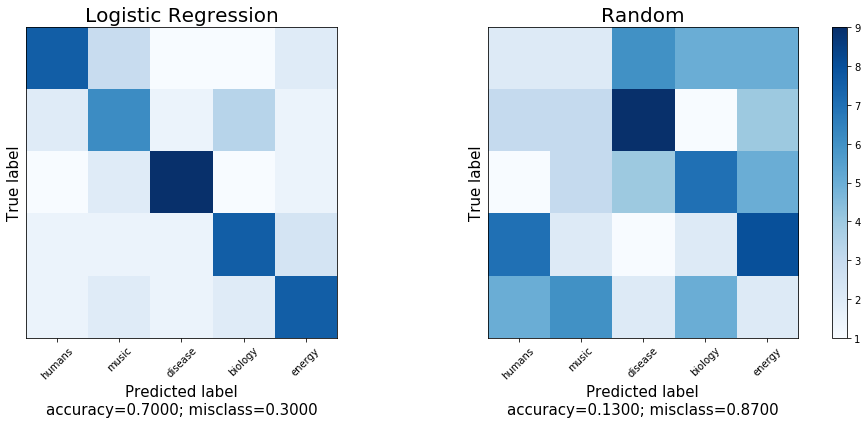

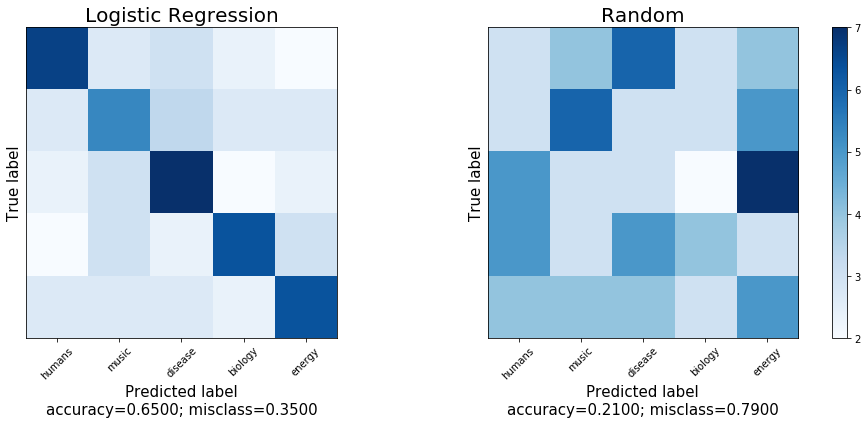

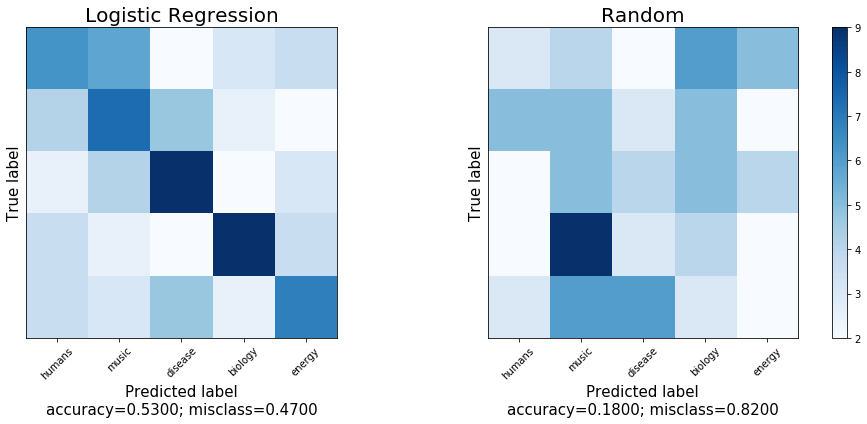

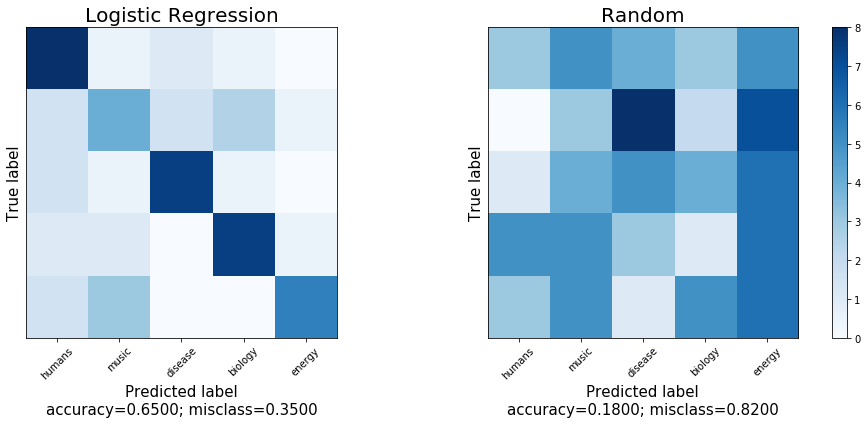

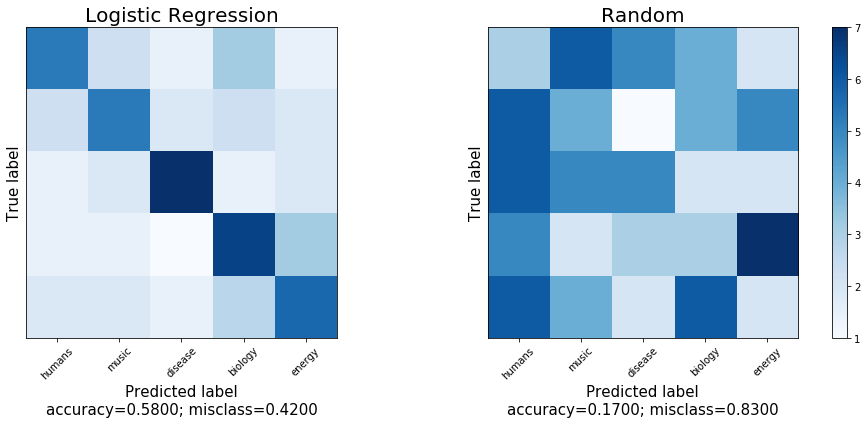

In [74]:
test_fraction = 0.1
number_of_splits = 5
sss = StratifiedShuffleSplit(n_splits=number_of_splits, 
                             test_size=int(test_fraction * len(downsampled_data)))
splitted_ixs = sss.split(tfidf_matrix, labels)

current_accuracy = 0
for train_ixs, test_ixs in splitted_ixs:
    X_train, y_train = tfidf_matrix[train_ixs], labels[train_ixs]
    X_test, y_test = tfidf_matrix[test_ixs], labels[test_ixs]

    lr_model = LogisticRegression(n_jobs=-1, penalty='l2',
                                  max_iter=200, solver='saga')

    lr_model.fit(X_train, y_train)

    
    prediction = np.array(lr_model.predict(X_test))
    
    cm = confusion_matrix(y_test, prediction)
    
    # generate random labels
    rand_predictions = np.random.choice(np.arange(NUM_CLASSES), len(prediction))
    cm_rand = confusion_matrix(y_test, rand_predictions)
    
    #save accuracy
    current_accuracy += np.trace(cm) / float(np.sum(cm))

    plt.figure(figsize=(16, 6))

    plt.subplot(1,2,1)
    plot_confusion_matrix(cm, target_names=cluster_names, title = 'Logistic Regression', cmap='Blues')

    plt.subplot(1,2,2)
    plot_confusion_matrix(cm_rand, target_names=cluster_names, title = 'Random', cmap='Blues')

In [0]:
current_accuracy  = current_accuracy/float(number_of_splits)
methods_performance['LR_undersampled'] = current_accuracy

Now its much better, but firstly it's still a bad performance. And secondly, it is not very fair to change the distribution of data that we have. So we used it just to show that setting of our task is very hard, especially for simple machine learning models.

Now we will try advanced models learned during the course

#Neural models

## BERT

In [0]:
path_to_data = 'gdrive/My Drive/Colab Notebooks/project/'

In [0]:
data = pd.read_csv(os.path.join(path_to_data, 'all_data_labeled.tsv'), sep='\t')

In [79]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 415340.29B/s]


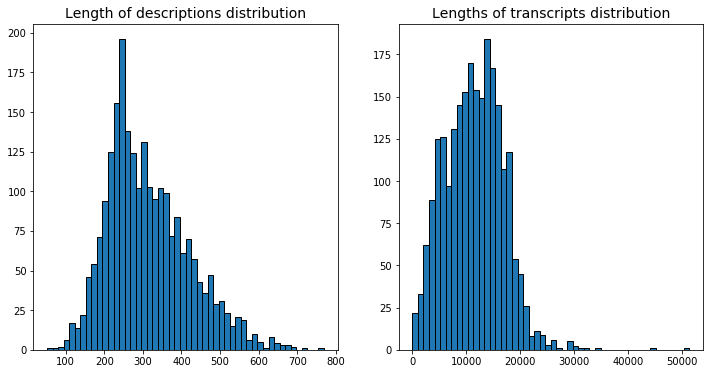

In [83]:
lengths = np.zeros((len(data),2))
for i in range(len(data)):
    lengths[i] = (len(data['description'][i]), len(data['transcript'][i]))
plt.figure(figsize=[12.,6.])
plt.subplot(121)
plt.title('Length of descriptions distribution', fontsize=14)
plt.hist(lengths[:,0], bins=50, edgecolor='black')
plt.subplot(122)
plt.title('Lengths of transcripts distribution', fontsize=14)
plt.hist(lengths[:,1], bins=50, edgecolor='black');

Since BERT has limitation on possible length of inputs we decided here to not analyze transcripts themselves but rather descriptions of videos. Because in this case truncating some texts will not be so significant as in long sentences

For texts that are longer than 510 tokens we will use their first and last 255 tokens. Texts that are shorter than 510 we will pad with zeros and hide them with attention masks

In [0]:
def k_truncate_vectorize(text, label, k):
    max_len = 2*k+2

    new_words = []
    input_masks = []
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        if tokens == []:
            continue
        new_words += tokens
        input_masks += [1] * len(tokens)
        if len(new_words) > max_len-2:
            new_words = ['[CLS]'] + new_words[:k] + new_words[-k:] + ['[SEP]']
            input_masks = [1] + input_masks[:k] + input_masks[-k:] + [1]
        else:
            new_words = ['[CLS]'] + new_words + ['[SEP]']
            input_masks = [1] + input_masks + [1]
  

    input_ids = tokenizer.convert_tokens_to_ids(new_words)

    padding = [0] * (max_len - len(input_ids))
    input_ids += padding 
    input_masks += padding

    assert len(input_ids) == max_len
    assert len(input_masks) == max_len

    label_id = [int(label)] 

    return torch.tensor(input_ids), torch.tensor(input_masks), torch.tensor(label_id) 


def k_truncate_preprocess(X, y, k):
    X_train, attention_masks_train, y_train = [], [], []
    for i, (t, l) in enumerate(zip(X, y)):
        if i%1000 == 0:
            print(i)
        a, c, d = k_truncate_vectorize(t, l, k)
        X_train.append(a)
        attention_masks_train.append(c)
        y_train.append(d)

    for i in range(len(X_train)):
        X_train[i] = (X_train[i], attention_masks_train[i], y_train[i])

    return X_train

In [0]:
texts = data['description']
labels = data['major_label'].apply(int)

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=37, stratify=labels)

In [0]:
X_train = k_truncate_preprocess(X_train, y_train, 255)
print('finished preprocessing of train set')
X_test = k_truncate_preprocess(X_test, y_test, 255)
print('finished preprocessing of test set')

In [0]:
def batch_accuracy(preds, labels):
    q = 0   
    for i in range(preds.shape[0]):
        prediction = torch.argmax(preds[i])
        if prediction.item() == labels[i].item():
            q += 1
    return q

def train_epoch(model, train_dataset, bs, with_clipping=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_losses = []
    train_right_answers = 0
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

    for j, train_batch in enumerate(train_loader):
        if j%100==9:
            print(j)

        model.train()
        b_ids, b_mask, b_labels = train_batch
        b_ids = b_ids.to(device)
        b_mask = b_mask.to(device)
        b_labels = b_labels.to(device)

        model.zero_grad()

        output = model(b_ids, token_type_ids=None, attention_mask=b_mask, labels=b_labels)
        loss = output[0]
        logits = output[1]

        train_losses.append(loss.item())
        train_right_answers += batch_accuracy(logits, b_labels)

        loss.backward()
        if with_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()
    
    print("Last average batch_loss on train: {}, \t Accuracy: {}".format(train_losses[-1], train_right_answers/(j+1)/bs))
    return train_losses, train_right_answers/(j+1)/bs

In [0]:
BATCH_SIZE = 4
MAX_N_EPOCHS = 10
LEARNING_RATE = 2e-5

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(set(labels))).to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0.1, t_total=(len(X_train) // BATCH_SIZE)*MAX_N_EPOCHS)

train_losses = []
train_accs = []

n_batches = len(X_train)//BATCH_SIZE

for i in range(MAX_N_EPOCHS):
    stats = train_epoch(model, X_train, bs=BATCH_SIZE)
    print(f"Epoch {i} finished.")
    train_losses += stats[0]
    train_accs.append(stats[1])

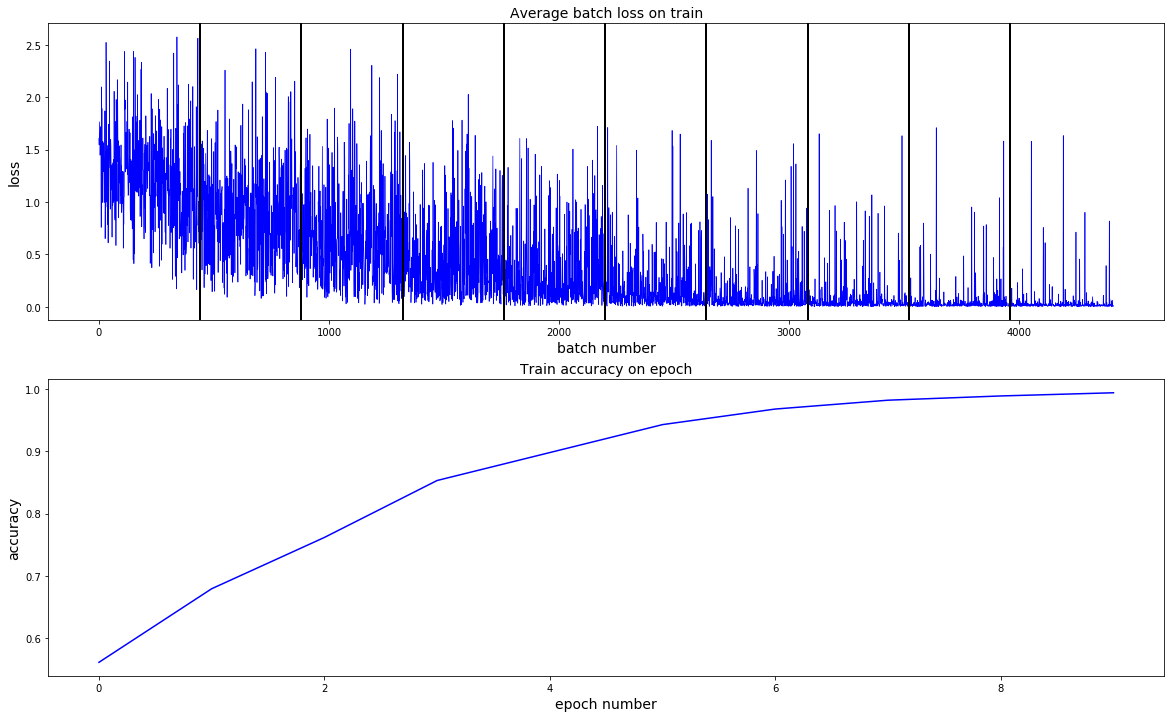

In [89]:
plt.figure(figsize=[20., 12.])
plt.subplot(211)
plt.title("Average batch loss on train", fontsize=14)
plt.plot(train_losses, c='b', linewidth=0.7)
for x in [len(X_train)//BATCH_SIZE*(i+1) for i in range(MAX_N_EPOCHS-1)]:
  plt.axvline(x, c='black', linewidth=2)
plt.xlabel("batch number", fontsize=14)
plt.ylabel("loss", fontsize=14)

plt.subplot(212)
plt.title("Train accuracy on epoch", fontsize=14)
plt.plot(train_accs, c='b')
plt.xlabel("epoch number", fontsize=14)
plt.ylabel("accuracy", fontsize=14);

In [0]:
def predict_test(model, test_data):
    preds = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    test_loader = DataLoader(test_data, batch_size=3)
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            b_ids, b_mask, b_labels = test_batch
            b_ids = b_ids.to(device)
            b_mask = b_mask.to(device)
            
            logits = model(b_ids, token_type_ids=None, attention_mask=b_mask)
            b_preds = logits[0]
            for logit in b_preds:
                pred = torch.argmax(logit)
                preds.append(pred.item())
    
    return preds

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, verbose=False):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(cm) / float(np.sum(cm))

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if verbose:
        print(cm)

    fig, ax = plt.subplots(figsize=[10.,10.])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print('Predicted label accuracy={:0.4f}'.format(accuracy))
    return ax

In [0]:
preds = predict_test(model, X_test)

Normalized confusion matrix
Predicted label accuracy=0.6565


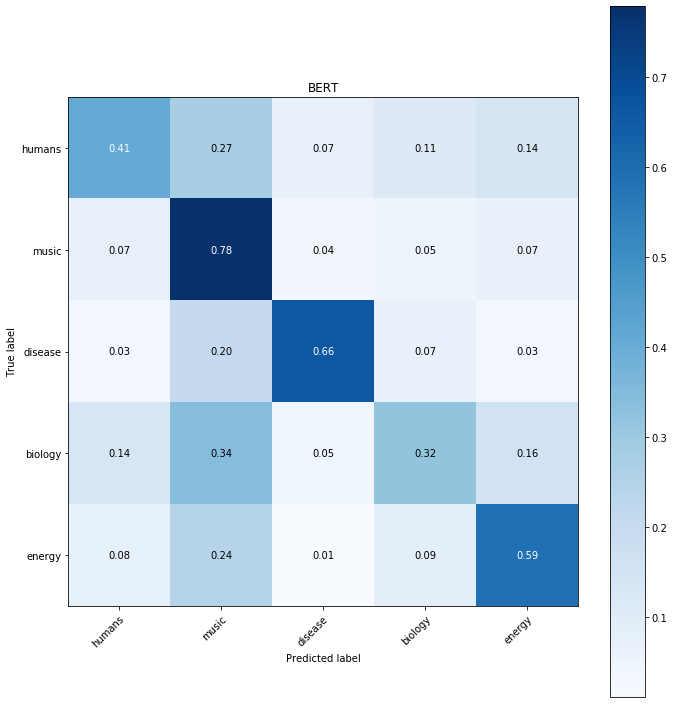

In [93]:
cluster_names = 'humans music disease biology energy'.split()

plot_confusion_matrix(preds, y_test, cluster_names, normalize=True, title='BERT', cmap='Blues')

In [0]:
cm = confusion_matrix(preds, y_test)
methods_performance['BERT'] = np.trace(cm) / float(np.sum(cm))

## Doc2Vec

In [0]:
data = pd.read_csv(os.path.join(path_to_data, 'all_data_labeled.tsv'), sep='\t')

texts = data['transcript']
documents = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i,text in enumerate(texts)]

In [97]:
%%time
vector_size=50
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
  
model.build_vocab(documents)

CPU times: user 12.6 s, sys: 93.3 ms, total: 12.7 s
Wall time: 12.8 s


In [98]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 9min 23s, sys: 4.44 s, total: 9min 27s
Wall time: 4min 59s


In [103]:
%%time
X_train = pd.DataFrame(np.zeros((len(texts),vector_size)))
for i in range(len(texts)):
    vector = model.infer_vector(documents[i].words)
    X_train.iloc[i, :] = vector

CPU times: user 4min 38s, sys: 162 ms, total: 4min 38s
Wall time: 4min 38s


In [0]:
y_train = data['major_label'].apply(int)

Now we apply logistic regression to this data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=37, stratify=y_train)

In [106]:
clr = LogisticRegression(random_state=37)
clr.fit(X_train, y_train)

preds = clr.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Normalized confusion matrix
Predicted label accuracy=0.6548


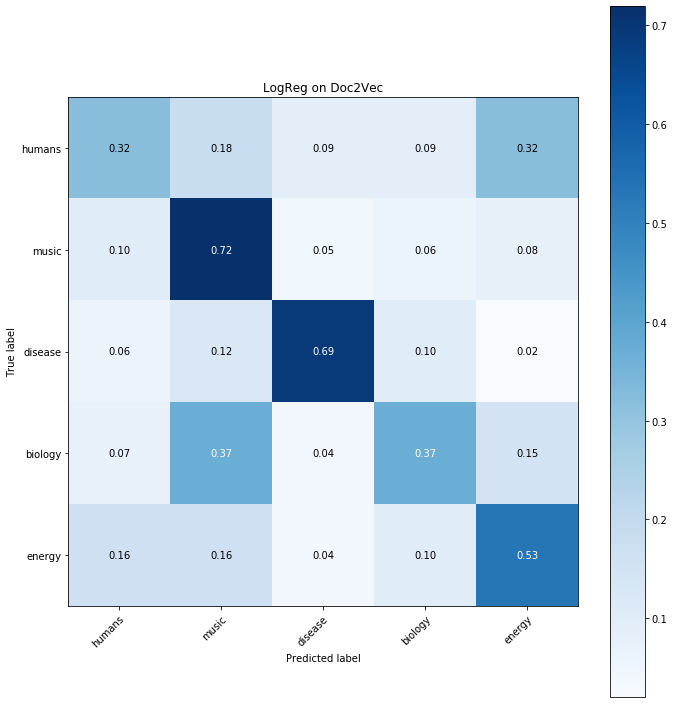

In [107]:
cluster_names = 'humans music disease biology energy'.split()
plot_confusion_matrix(preds, y_test, cluster_names, normalize=True, title='LogReg on Doc2Vec', cmap='Blues')

In [0]:
cm = confusion_matrix(preds, y_test)
methods_performance['doc2vec_LR'] = np.trace(cm) / float(np.sum(cm))

# Results

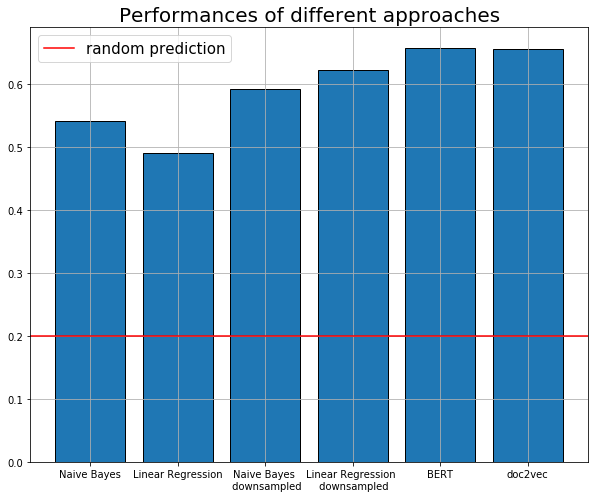

In [122]:
plt.figure(figsize=(10, 8))
plt.title('Performances of different approaches', fontsize=20)
plt.grid(True)
plt.bar(np.arange(len(methods_performance)), 
        np.array(list(methods_performance.values())), 
        edgecolor = 'black')
colnames = ['Naive Bayes', 'Linear Regression', 
            'Naive Bayes {} downsampled'.format('\n'), 
            'Linear Regression {} downsampled'.format('\n'), 
            'BERT', 'doc2vec']
_ = plt.xticks(np.arange(len(methods_performance)), colnames)
plt.axhline(y=0.2, c='r', label='random prediction')
plt.legend(fontsize=15)

# Conclusion

In this project we were trying to classify large texts (transcripts of TED talks) into multiple classes. 

First problem that we encountered was reducing amount of classes. Each video had a set of tags, so we applied word embeddings to cluster tags into adequate number of classes to perform further classification.

Then we have conducted a comparison analysis of simple NLP models that were studied during the course. Each of them demanded specific preprocessing such as tokenization, stemmization, etc. Obtained class separation was very unbalanced which was another big obstacle for basic models.

Finally we have come up with advanced models that have shown adequate results (considering how difficult our task was) on validation data 